# Basic Model: Ambulance + Overdose



## Ambulance Call-outs Model

$n_{A}$: sample size   
$x_{A}$: the total number who confirmed they did call an ambulance  
$p_{A}$: probability of a person call an ambulance   

$$x_{A} \sim Bin(n_{A},p_{A})$$

**We assume $n_{A}=1000, p_A = 0.8$.**  
**Suppose the prior of $p_A$ is noninformative.** 
$$p(p_A) \sim Beta(1,1)$$

## Overdose Model
Now we plug in this values into the overdose model and obtain possible $O_t$ values **assuming we have $U_t$ values.**
Also, we have priors.


$$z_{t} \sim N(\mu, \sigma^{2})$$  
$$\lambda_{t}^{OD} = \exp(z_{t})$$  
$$O_{t} \sim Poi(\lambda_{t}^{OD}N)$$  
$$U_t \sim Bin(O_t, p_A)$$  
For simplicity we set N =10000 for now. We need to generate reasonable $U_t$ values first. Note that $U_t$ comes from $\mu, \sigma$ following all the way through the overdose model.  



$\mu=\log0.05, \sigma=1, N=10000$.   
We suppose survey data exists: ($n_A, x_A$) known.  

**We set for our prior parameters:** $$\mu \sim U(-10,0)$$  $$\sigma \sim U(0,5)$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

In [2]:
import platform
platform.python_version()

'3.7.4'

Below is the function that generate data from simulation.

In [3]:
def sim_ambulance_overdoses(random=1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, n_a=1000, n_T=12):
    '''
    Simulate overdoses data, ambulance-call outs survey data and related variables 
    -----------
    mu_z- float 
        log rate for lambda
    
    sigma_z -float
        variance of log lambda
    
    N - int
        Total size of population
        
    p_a - float
        probability of calling ambulance at the scene of overdose
    
    n_a - int
        total number of survey
    
    n_T - int
        number of time points  
    '''
    #set.seed(1)
    np.random.seed(random)
    
    # generate z_t values
    zt = np.random.normal(loc=mu_z, scale = sigma_z, size = n_T)
    
    # convert into lambda_t
    lmd_t = np.exp(zt)
    
    # generate O_t data set
    o_t = np.random.poisson(lmd_t*N)
    
    # generate U_t data set
    u_t = np.random.binomial(n=o_t, p=p_a)
    
    # generate x_t data set
    x_a = np.random.binomial(n=n_a, p=p_a)
    
    return {'o_t':o_t, 'u_t':u_t, 'x_a':x_a, 'n_a':n_a,'N':N}

In [4]:
data= sim_ambulance_overdoses()

In [5]:
data['o_t'].shape


(12,)

In [6]:
def create_model(data):
    N = data['N']
    
    with pm.Model() as model:
        # priors 
        p_a = pm.Beta('p_a', alpha=1, beta=1)
        # note that this prior is to be changed later
        mu_z = pm.Uniform('mu_z', -10, 0)
        sigma_z = pm.Uniform('sigma_z',0,5)
        
        # latent variables
        z_t = pm.Normal('z_t', mu=mu_z, sigma=sigma_z, shape=(12,))
        lmb_t = pm.Deterministic('lmb_t', tt.exp(z_t))
#       o_t = pm.Poisson('o_t', lmb_t*N)
        o_t = pm.Gamma('o_t', mu=lmb_t*N , sigma=tt.sqrt(lmb_t*N), shape=(12,) )
        # MCMC with discrete random variable is hard to do sampling...
        # We approximate this to Gamma dist
        
        
        #likelihood 
        pm.Poisson('u_t', o_t*p_a, observed=data['u_t'])
        pm.Binomial('x_a', n=data['n_a'], p =p_a, observed=data['x_a'])
        
    return model
        

Difference between my prior and Mike's prior exists.

In [7]:
model = create_model(data)


In [8]:
with model:
    trace = pm.sample(1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 219.31draws/s]


## Boxplot of $O_t$
$O_t$ is the variable of interest that we can never get data set. 
Boxplot of $O_t$ 

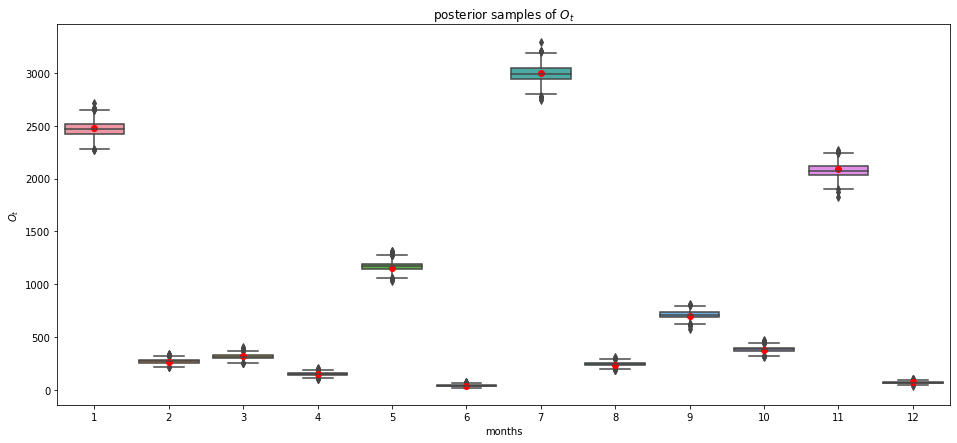

In [9]:
a4_dims = (16,7)
fig, ax = plt.subplots(figsize=a4_dims)
df = pd.DataFrame(data=trace['o_t'], columns=range(1,13))
ax=sns.boxplot(data=df)
plt.title("posterior samples of $O_t$")
ax.set_xlabel('months')
ax.set_ylabel('$O_t$')
ax2 = plt.plot(range(0,12), data['o_t'],'ro')


In [10]:
trace['o_t'].shape

(2000, 12)

# Posterior Predictive Check

## PPC: $U_t$  


In [11]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)


100%|██████████| 1000/1000 [00:03<00:00, 306.36it/s]


We would like to see if there is discrepency between original data set (likelihood) and the posterior predictive distribution.

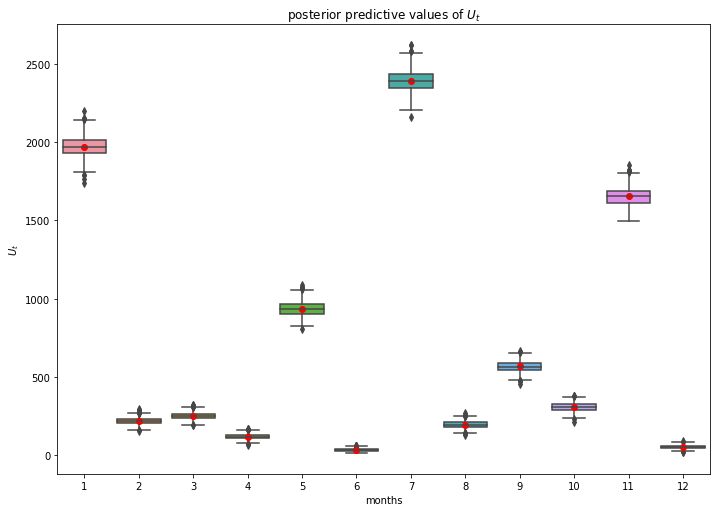

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title("PPC: U_t")
df = pd.DataFrame(data=ppc['u_t'], columns=range(1,13))
ax=sns.boxplot(data=df)
plt.title("posterior predictive values of $U_t$")
ax.set_xlabel('months')
ax.set_ylabel('$U_t$')
ax2 = plt.plot(range(12), data['u_t'],'ro')

## PPC: $x_A$

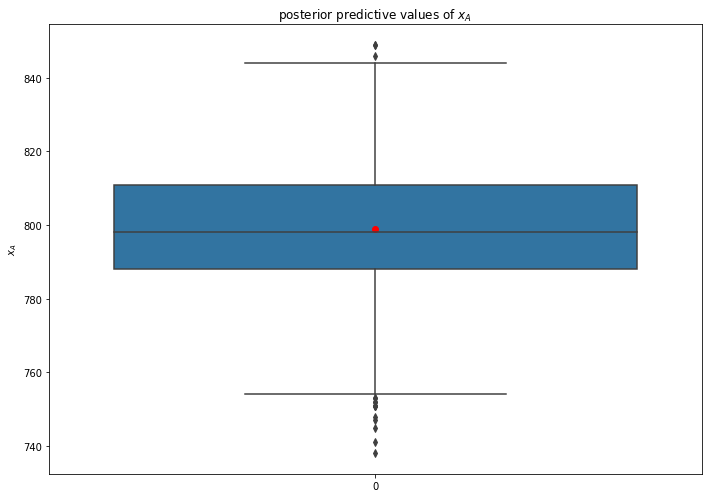

In [13]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
df= pd.DataFrame(data=ppc['x_a'])
ax=sns.boxplot(data=df)
ax.set_title('posterior predictive values of $x_A$')
# ax.set_xlabel('month')
ax.set_ylabel('$x_A$')
ax2 = plt.plot(data['x_a'],'ro')



In [14]:
ppc['x_a'].shape

(1000,)

The posterior predictive values are consistent with the expected value 800.
We have the most variation between the PPC and the likelihood. 

# As A Function ($P_A$(biased), N)
We want to see the effect of $P_A$: how much effect does $P_A$ has on our inference?  
bias term on $p_A$:  
Bias = $\theta -\hat{\theta} = p_A- \hat{p}_A$   
$\hat{p}_A = p_A + bias(p_A)$  

$p_A$ still be set to 0.8 but $\hat{p}_A$ will have some bias. 

$p_A$ is inferred from survey data ($n_A, x_A$). Since our estimation of the parameter is from there, we suppose that our survey data is contaminated. That is, our estimation of $p_A$ has a bias term and see how it affects the estimaton of $O_t$, our ultimate interest.

Probably the common case is underestimate the $p_A$. This can happen since drug addicts or witnesses may not want to reveal that they called aubulance for some credential concern.  

Hence, we build a function that can have bias argument so that the survey data (likelihood) may lead underestimated $p_A$ values.

In [15]:
def sim_ambulance_overdoses_bias(random = 1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, bias = -0.2, n_a=1000, n_T=12):
    '''
    Simulate overdoses data, ambulance-call outs survey data and related variables considering 
    possible bias term for p_a
    -----------
    mu_z- float 
        log rate for lambda
    
    sigma_z -float
        variance of log lambda
    
    N - int
        Total size of population
        
    p_a - float
        probability of calling ambulance at the scene of overdose
        
    bias - float
        bias term affecting the survey data 
    
    n_a - int
        total number of survey
    
    n_T - int
        number of time points  
    '''
    #set.seed(1)
    np.random.seed(random)
    
    # generate z_t values
    zt = np.random.normal(loc=mu_z, scale = sigma_z, size = n_T)
    
    # convert into lambda_t
    lmd_t = np.exp(zt)
    
    # generate O_t data set
    o_t = np.random.poisson(lmd_t*N)
    
    # generate U_t data set
    u_t = np.random.binomial(n=o_t, p=p_a)
    
    # generate x_t data set
    x_a = np.random.binomial(n=n_a, p=p_a+ bias)
    
    return {'o_t':o_t, 'u_t':u_t, 'x_a':x_a, 'n_a':n_a,'N':N, 'bias':bias}

So let's make a function. 

In [16]:
def test_robust(random=1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, bias = -0.2, n_a=1000, n_T=12):
    data = sim_ambulance_overdoses_bias(random=random, mu_z=mu_z, sigma_z=sigma_z,
                            N=N, p_a=p_a, bias = bias, n_a=n_a, n_T=n_T)
    model = create_model(data)
    with model:
        trace = pm.sample(1000, chains=2)
    ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
    
    return {'data':data, 'model':model, 'trace':trace, 'ppc':ppc}


In [17]:
my_list_unbiased = test_robust(bias = 0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
100%|██████████| 1000/1000 [00:01<00:00, 875.09it/s]


In [18]:
my_list_under = test_robust()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 212.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 1000/1000 [00:01<00:00, 752.73it/s]


In [19]:
my_list_over = test_robust(bias = +0.1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
100%|██████████| 1000/1000 [00:01<00:00, 776.44it/s]


Since there is some weird process going under, let us check the acutal data sets here. 

In [20]:
my_list_unbiased['data']['u_t']


array([1969,  217,  253,  119,  934,   34, 2392,  196,  569,  308, 1655,
         55])

In [21]:
my_list_under['data']['u_t']


array([1969,  217,  253,  119,  934,   34, 2392,  196,  569,  308, 1655,
         55])

In [22]:
my_list_over['data']['u_t']


array([1969,  217,  253,  119,  934,   34, 2392,  196,  569,  308, 1655,
         55])

**so what?**

I may need aother function to see the boxplots of ppc and posterior distrubiton on interest.

In [23]:
def visualization(mylist= None, post= False, u_t = False, x_a = False, string='string'):
    
    if post is True: 
        # Boxplot for O_t, the variable of interest
        a4_dims = (13, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        df1 = pd.DataFrame(data=mylist['trace']['o_t'], columns=range(1,13))
        ax = sns.boxplot(data=df1)
        ax.set_title("posterior samples of $O_t$ "+string)
        ax.set_xlabel('months')
        ax.set_ylabel('$O_t$')   
        ax = plt.plot(range(12), mylist['data']['o_t'],'ro')
              
    
    if u_t is True:
        # boxplot of ppc : u_t
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        df2= pd.DataFrame(data=mylist['ppc']['u_t'], columns=range(1,13))
        ax = sns.boxplot(data=df2)
        ax.set_title("posterior predictive values of $U_t$: "+string)
        ax.set_xlabel('months')
        ax.set_ylabel('$U_t$') 
        ax= plt.plot(range(12), mylist['data']['u_t'],'ro')

    
    if x_a is True: 
        # boxplot of ppc : x_a
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        df3= pd.DataFrame(data=mylist['ppc']['x_a'])
        ax=sns.boxplot(data=df3)
        ax.set_title('posterior predictive values of $x_A$: '+string)
        ax2 = plt.plot( mylist['data']['x_a'],'ro')
#         ax.set_xlabel('months')
        ax.set_ylabel('$x_A$') 
        

Comparing $O_t$:  
bias -2 vs unbiased vs bias +1

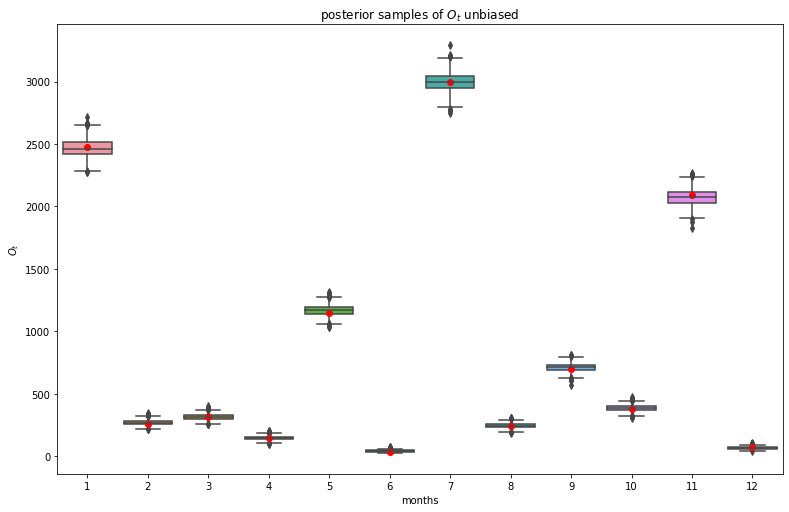

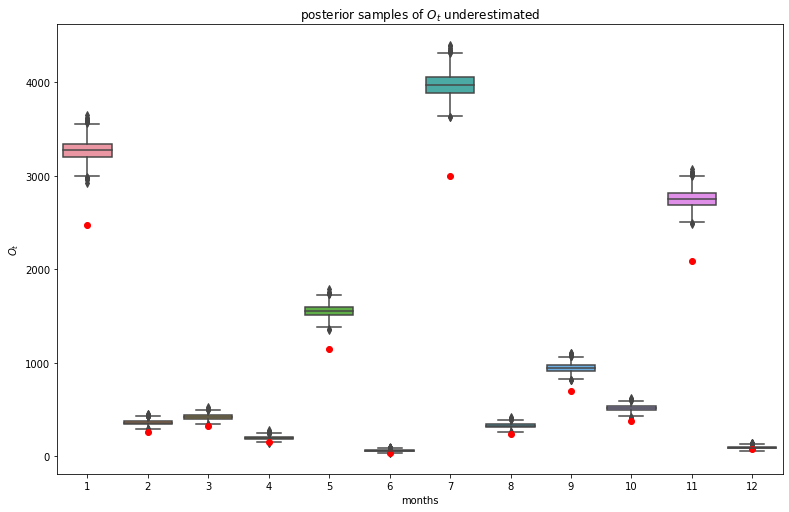

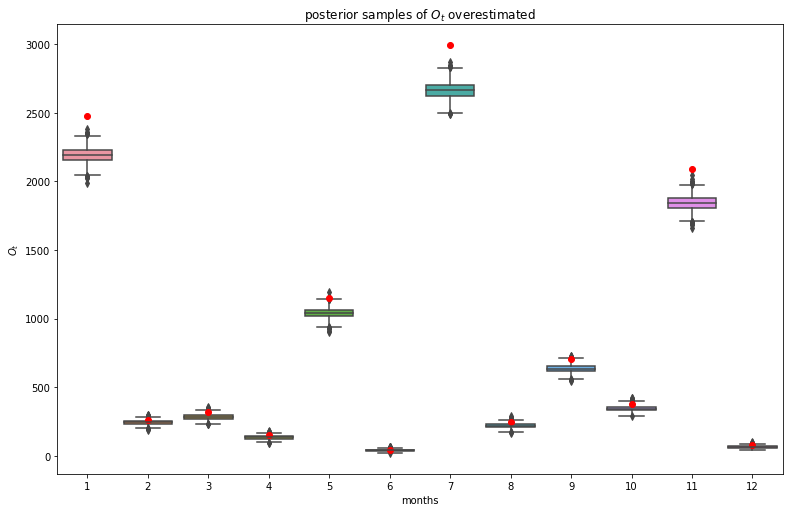

In [27]:
visualization(my_list_unbiased, post= True, string='unbiased')
visualization(my_list_under,post= True,string='underestimated')
visualization(my_list_over,post= True,string='overestimated')

ALSO maybe I should make another function to compare the three cases...

Comparing $U_t$  
bias -2 vs unbiased vs bias +1

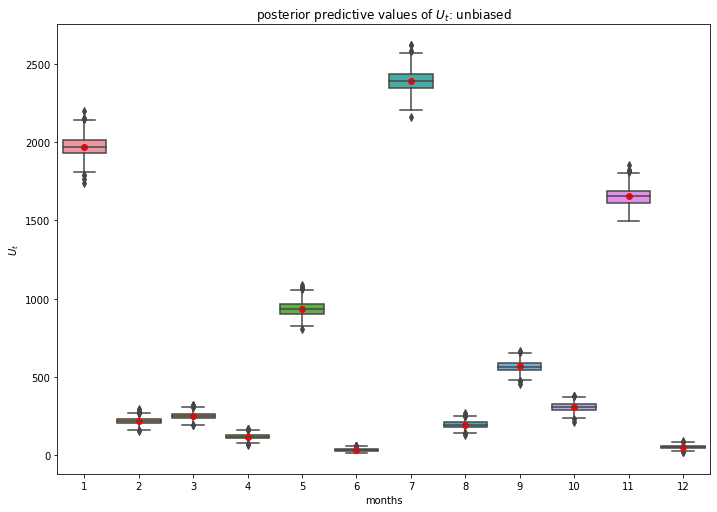

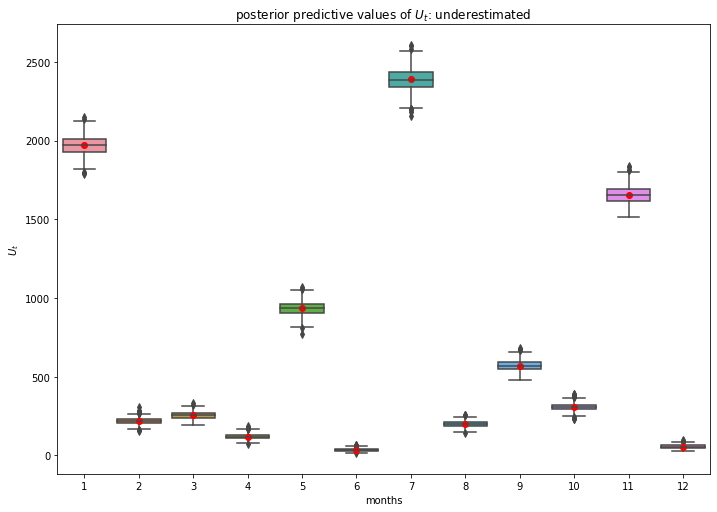

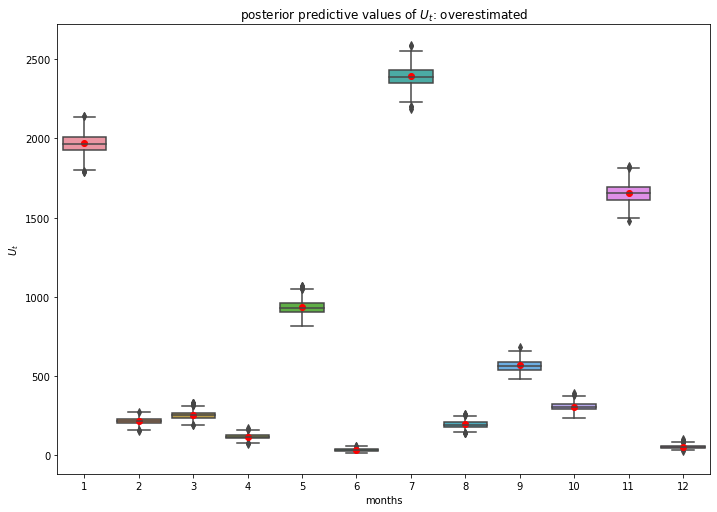

In [28]:
visualization(my_list_unbiased, u_t= True, string='unbiased')
visualization(my_list_under,u_t= True,string='underestimated')
visualization(my_list_over,u_t= True,string='overestimated')

Comparing $x_A$  
bias -2 vs unbiased vs bias +1

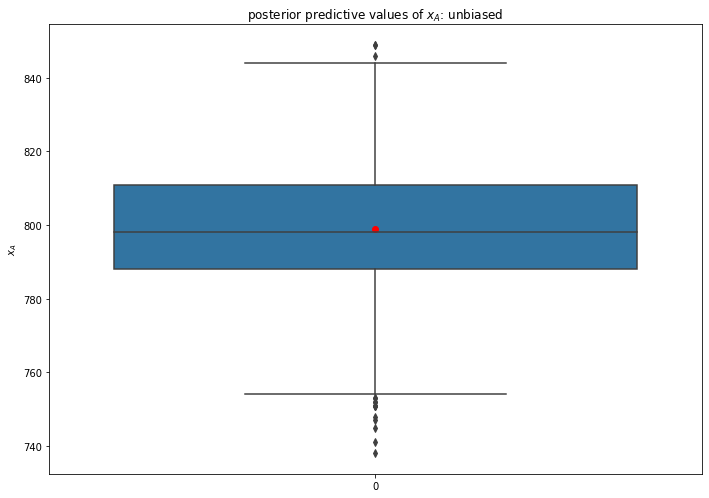

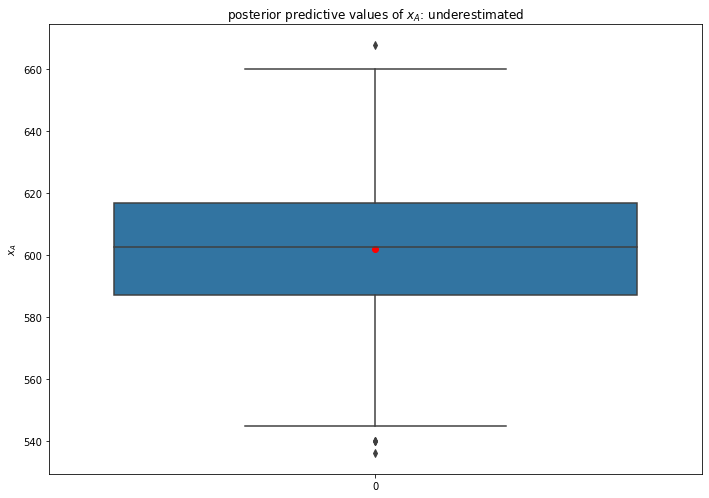

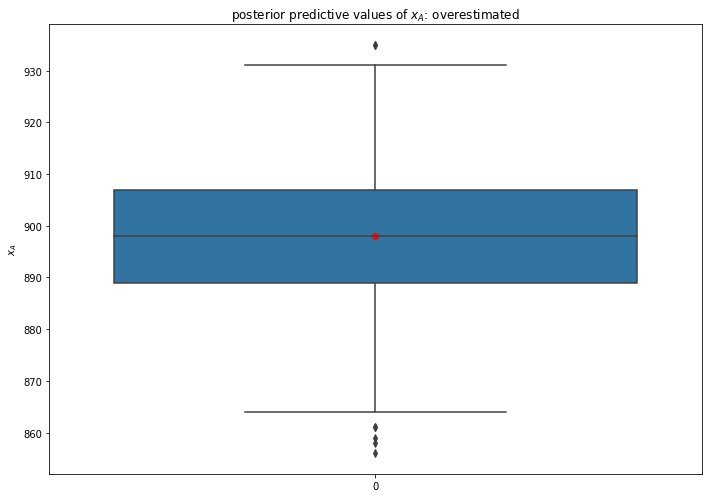

In [29]:
visualization(my_list_unbiased, x_a= True, string='unbiased')
visualization(my_list_under,x_a= True,string='underestimated')
visualization(my_list_over,x_a= True,string='overestimated')

### Interactive plot?

### Make a object rather than just a function ? 